# Environment

## Libraries

In [1]:
import os, subprocess, json, requests, getpass, urllib.parse, sys, pathlib, warnings, \
numpy as np, pandas_profiling, seaborn as sns, pandas as pd, matplotlib.pyplot as plt, \
google.cloud.bigquery as bigquery

from bs4 import BeautifulSoup
from astropy.visualization import hist as astro_hist
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Specifying the Working Directory

In [2]:
workingdir = os.getcwd()
d = [d for d in os.listdir(workingdir)]
n = 0
while not set(["notebook"]).issubset(set(d)):
    workingdir = str(pathlib.Path(workingdir).parents[0])

    d = [d for d in os.listdir(str(workingdir))]
    n += 1
    if n > 5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

## Dealing with Warnings

In [3]:
pd.set_option("mode.chained_assignment", None)

## Function Definitions

In [4]:
def create_wordcloud(df: pd.DataFrame, what: str):
    posts = df[["body"]].apply(lambda x: " ".join(x), axis=0)[0]
    soup = BeautifulSoup(posts, "html.parser")
    obj_array = soup.find_all(what)
    text = ""

    for obj in obj_array:
        text += obj.text

    stopwords = set(STOPWORDS)
    wordcloud_obj = WordCloud(stopwords=stopwords).generate(text)

    return wordcloud_obj

In [5]:
def code_block_number(string):
    soup = BeautifulSoup(string, 'html.parser')
    obj_array = soup.find_all('code')

    return(len(obj_array))

# Exploratory Data Analysis

In [6]:
client = bigquery.Client()

## Tags

<a href='https://stackoverflow.com/help/tagging' target='_blank'>What are tags, and how should I use them?</a>

In [7]:
query = """SELECT
 *
FROM
  `bigquery-public-data.stackoverflow.tags`
ORDER BY
  count desc"""
df_tags = client.query(query).to_dataframe()

### How are the Tags Distributed?

In [8]:
features = ["count"]

In [9]:
df_tags[features].describe()

count
count  5.566500e+04
mean   9.661615e+02
std    1.810551e+04
min    1.000000e+00
25%    1.000000e+01
50%    3.900000e+01
75%    1.650000e+02
max    1.862833e+06

[(0, 600), Text(0, 0.5, 'Number of Tags'), Text(0.5, 0, 'Occurences')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


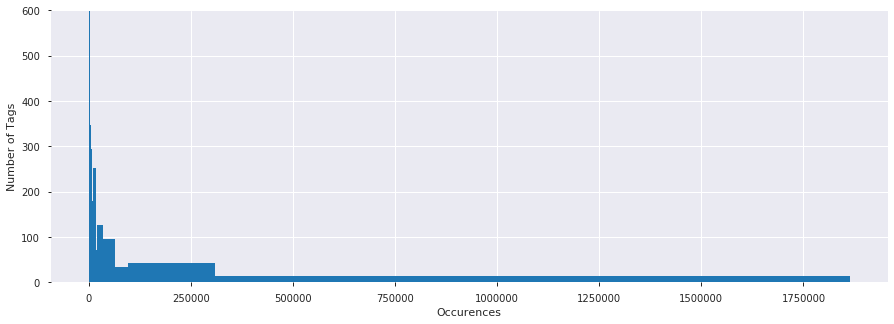

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

astro_hist(df_tags["count"], bins="blocks", histtype="stepfilled")

ax.set(ylim=[0, 600], xlabel="Occurences", ylabel="Number of Tags")

### Which Tags Are Most Frequent?

In [11]:
df_tags.head()

id    tag_name    count  excerpt_post_id  wiki_post_id
0   3  javascript  1862833        3624960.0     3607052.0
1  17        java  1581854        3624966.0     3607018.0
2   9          c#  1339575        3624962.0     3607007.0
3   5         php  1303327        3624936.0     3607050.0
4  16      python  1236812        3624965.0     3607014.0

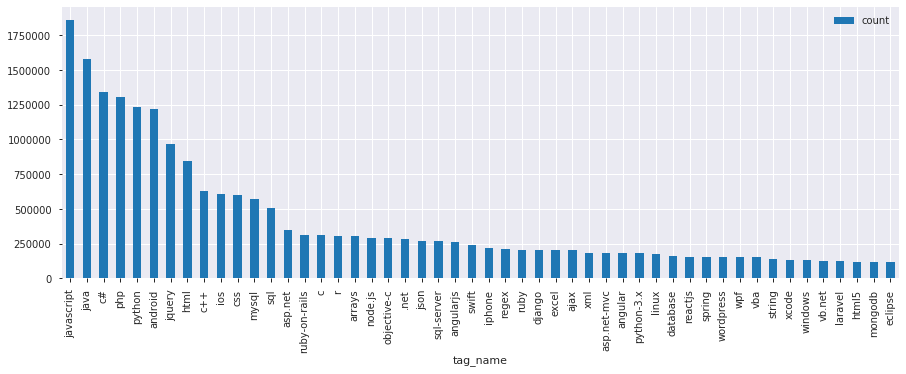

In [12]:
df_tags.iloc[0:50].plot(x="tag_name", y="count", kind="bar", figsize=(15, 5));

### Cumulative Frequency of the Most Frequent Tags

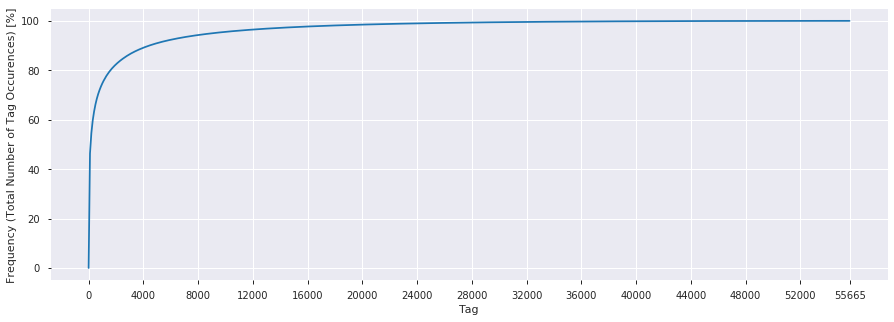

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
total = df_tags["count"].sum()
y_values = []
x_values = []

for category in range(0, len(df_tags), 100):
    value = df_tags["count"].iloc[0:category].sum()
    y_values.append((value / total) * 100)
    x_values.append(category)

ax.plot(x_values, y_values, color="#1f77b4")
ax.set(xlabel="Tag", ylabel="Frequency (Total Number of Tag Occurences) [%]")
ax.set_xticks(list(range(0, len(df_tags), 4000)) + [len(df_tags)]);

## Posts

In [14]:
query = """SELECT
  *
FROM
  `nlp-text-classification.stackoverflow.posts_p1_subset`"""
df_posts = client.query(query).to_dataframe()

In [15]:
features = [
    "title",
    "body",
    "answer_count",
    "comment_count",
    "favorite_count",
    "score",
    "tags",
    "view_count",
]
report_features = [
    "answer_count",
    "comment_count",
    "favorite_count",
    "score",
    "tags",
    "view_count",
]

In [16]:
df_posts[features].head()

title                                               body  answer_count  \
0  None  <p>You can simply nest it like this:</p> <pre>...           NaN   
1  None  <p>As you are using this VHOST on port 8080. Y...           NaN   
2  None  <p>Here is my environment and I can run scrapy...           NaN   
3  None  <p><a href= http://msdn.microsoft.com/en-us/li...           NaN   
4  None                                               None           NaN   

   comment_count  favorite_count  score tags  view_count  
0              0             NaN      0   []         NaN  
1              1             NaN      0   []         NaN  
2              2             NaN      0   []         NaN  
3              0             NaN      0   []         NaN  
4              0             NaN      0   []         NaN

### Report

In [17]:
posts_report = df_posts[report_features].profile_report()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [18]:
posts_report

### Code: Wordcloud

In [19]:
query = """SELECT
  *
FROM
  `nlp-text-classification.stackoverflow.posts_p1_subset`
  WHERE '{lang}' in UNNEST(tags)
  """

In [20]:
langs = df_tags['tag_name'].iloc[0:10]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


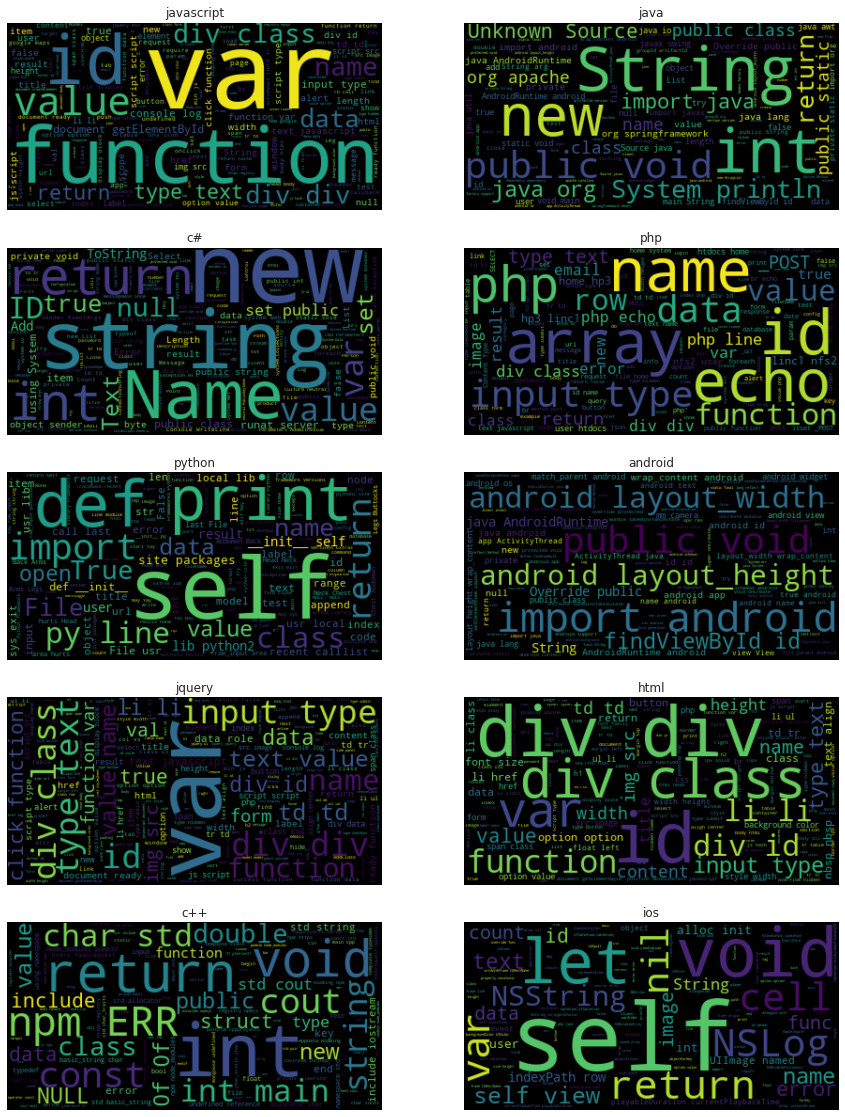

In [21]:
fig = plt.figure(figsize=(15, 20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = client.query(query.format(lang=lang)).to_dataframe()
    worcloud_temp = create_wordcloud(temp, "code")

    ax = fig.add_subplot(5, 2, num + 1)

    ax.imshow(worcloud_temp, interpolation="bilinear")
    ax.set(title=lang)
    ax.axis("off")

### Post: Wordcloud

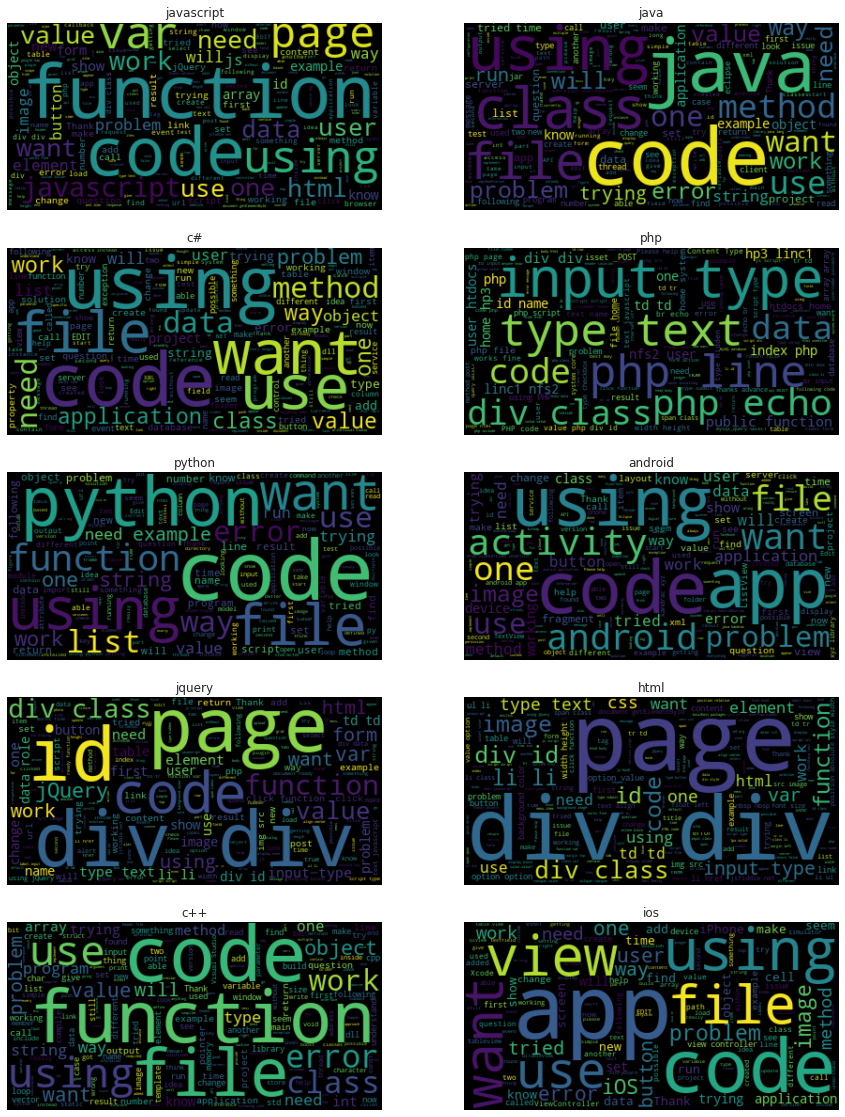

In [22]:
fig = plt.figure(figsize=(15, 20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = client.query(query.format(lang=lang)).to_dataframe()
    worcloud_temp = create_wordcloud(temp, "p")

    ax = fig.add_subplot(5, 2, num + 1)

    ax.imshow(worcloud_temp, interpolation="bilinear")
    ax.set(title=lang)
    ax.axis("off")

### How Many Posts Do Have a Codeblock?

In [23]:
query = """SELECT
  *, ARRAY_LENGTH(tags) as tag_count
FROM
  `nlp-text-classification.stackoverflow.posts_p1_subset`
  WHERE ARRAY_LENGTH(tags) >= 1 and tags[OFFSET(0)] <> ''
  """
df_analysis = client.query(query).to_dataframe()

In [24]:
df_analysis['codeblocks'] = df_analysis['body'] \
                                            .apply(lambda string: code_block_number(string))

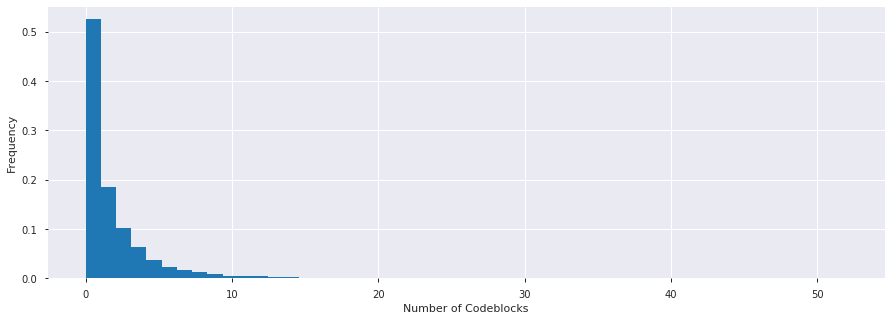

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

df_analysis['codeblocks'].plot(kind='hist', bins=50, 
                                            weights=np.zeros_like(df_analysis['codeblocks']) \
                                            + 1. / df_analysis['codeblocks'].size);

ax.set(xlabel='Number of Codeblocks', ylabel='Frequency');

### How Much Tags Are There Per Post?

In [ ]:
df_analysis['tag_count'].describe()

count    11795.000000
mean         2.964985
std          1.209472
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: tag_count, dtype: float64

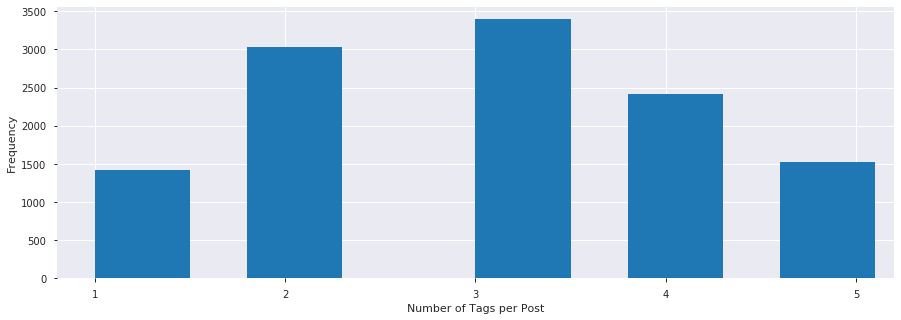

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.hist(df_analysis['tag_count'], width=0.5)

ax.set(xlabel='Number of Tags per Post', xticks=range(1,6), ylabel='Frequency');